In [1]:
#============== Install required libraries==============#
# !pip install --upgrade pip 
# !pip install opencv-python matplotlib

# Import standard libraries #
import os                                             # Work with file paths and directories
import cv2                                            # OpenCV for image/video loading, processing, tracking
import torch                                          # PyTorch for deep learning and tensor computations
import numpy as np                                    # numerical operations and arrays
import matplotlib.pyplot as plt                       #plotting graphs & visualizing images
from scipy.signal import savgol_filter                #library applies a Savitzky-Golay filter to a signal

In [2]:
#======================= Upload Video==================#
video_path = "/kaggle/input/cycle-input123/bicycle_video2.mp4" # give input video path


# Alternative #
# print("/content/tracking video2.mp4")   # Just prints the path where Colab stores files
# uploaded = files.upload()              # Opens a dialog to upload a file from your computer
# video_path = list(uploaded.keys())[0]  # Gets the name of the first uploaded file
# print("✅ Video uploaded:", video_path) # Confirms which video was uploaded

In [3]:
# =====================Load Frames=========================== #
cap = cv2.VideoCapture(video_path)  # Open the uploaded video file
frames = []                         # Empty list to store all video frames

# Check if video file opened successfully
if not cap.isOpened():
    raise FileNotFoundError(f"❌ Could not open video: {video_path}")

# Loop through video frame by frame
while True:
    ret, frame = cap.read()               # Read one frame from the video
    if not ret:                           # If no more frames to read, break the loop
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert from BGR (OpenCV default) to RGB
    frames.append(frame_rgb)              # Save the frame in the list

cap.release()                             # Release the video file (important to free memory)

# Convert list of frames into a single NumPy array
frames = np.array(frames, dtype=np.uint8)
print("✅ Frames loaded:", frames.shape)  # Show dimensions # (T, H, W, 3)

✅ Frames loaded: (344, 240, 426, 3)


In [4]:
# ===================== Convert to Tensor =======================#
# Check if GPU ("cuda") is available; otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Convert frames (NumPy array) ---> PyTorch tensor
# Shape steps:
#   frames: (T, H, W, 3)
#   permute(0, 3, 1, 2): (T, 3, H, W)  [move color channel before height/width]
#   unsqueeze(0): (1, T, 3, H, W)      [add batch dimension]
#   float(): convert to float32
#   to(device): move to GPU (if available)
video = torch.from_numpy(frames).permute(0, 3, 1, 2).unsqueeze(0).float().to(device)

print("✅ Video tensor shape:", video.shape)  #  Should be (1, T, 3, H, W)

# ==================== Load CoTracker ==========================#
# Load the CoTracker model from PyTorch Hub.
# "online" version: processes frame-by-frame in real time (slower, but streams)
# "offline" version: processes entire video at once (faster, good for Colab)
#cotracker = torch.hub.load("facebookresearch/co-tracker", "cotracker3_online").to(device)
cotracker = torch.hub.load("facebookresearch/co-tracker", "cotracker3_offline").to(device)

✅ Video tensor shape: torch.Size([1, 344, 3, 240, 426])
Downloading: "https://github.com/facebookresearch/co-tracker/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://huggingface.co/facebook/cotracker3/resolve/main/scaled_offline.pth" to /root/.cache/torch/hub/checkpoints/scaled_offline.pth


100%|██████████| 97.2M/97.2M [00:02<00:00, 49.9MB/s]


In [6]:
# ----------------- Define Queries -----------------
# Format: [frame_number, x, y]
# Example: track one point at frame 0, pixel (x,y)

queries = torch.tensor([
    [70., 125., 50.],   # first point
    # [0.,650., 300.],   # second point
    # [0., 500., 270.],
    # [0., 400., 275.],
    # [45., 75., 150.],
    # [45., 270., 90.],
    # [0., 50., 100.],
    # [0., 80., 70.],
    #  [0., 65., 90.],
    #  [0., 400., 320.]
], device=device)
# Send queries tensor to the same device (CPU or GPU)

In [7]:
# ----------------- Run Model -----------------
# Run CoTracker model on the video with the defined query points.

#   pred_tracks     → predicted (x,y) positions of each query point across frames
#   pred_visibility → confidence (visibility score) for each tracked point
pred_tracks, pred_visibility = cotracker(video, queries=queries[None])

#================= Reshape outputs ===================#
#pred_tracks shape:  (B, T, N, 2) ------> (T, N, 2)
#   B = batch size (1 video here)
#   T = number of frames
#   N = number of query points
#   2 = (x, y) coordinates
# Remove batch dimension (B) → shape becomes (T, N, 2)
pred_tracks = pred_tracks.squeeze(0).cpu().numpy()

# pred_visibility shape: (B, T, N)
# Remove batch dimension (B) → shape becomes (T, N)
pred_visibility = pred_visibility.squeeze(0).cpu().numpy()

In [8]:
# ----------------- Debugging: Check data types and contents -----------------
print("frames:", type(frames))              # Should be <class 'numpy.ndarray'> after conversion
print("pred_tracks:", type(pred_tracks))    # Should be <class 'numpy.ndarray'> (tracking results)
print("pred_visibility:", type(pred_visibility))  # Should be <class 'numpy.ndarray'> (visibility scores)
print("queries:", type(queries))            # Should be <class 'torch.Tensor'> (queries defined on device)
print("queries content:", queries)          # Prints actual query tensor values (frame, x, y)

frames: <class 'numpy.ndarray'>
pred_tracks: <class 'numpy.ndarray'>
pred_visibility: <class 'numpy.ndarray'>
queries: <class 'torch.Tensor'>
queries content: tensor([[ 70., 125.,  50.]])


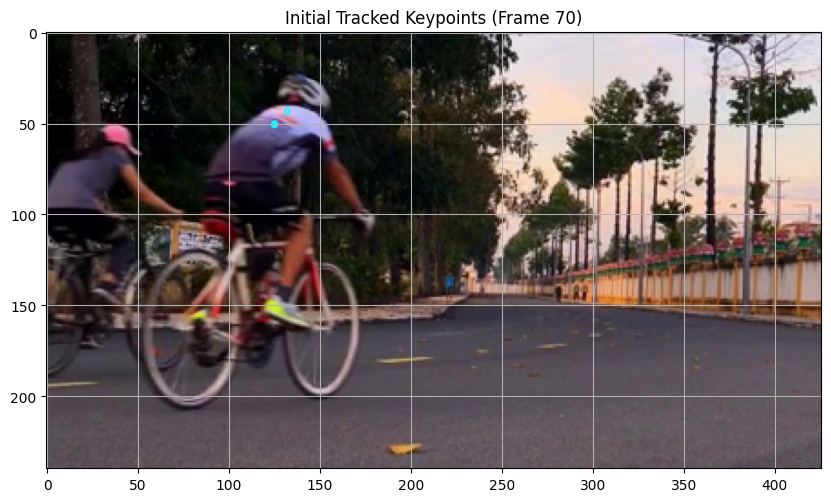

In [9]:
#To check points you defined in queries really land in the right spots on your video

def show_initial_points(frame, queries, step=50):
    plt.figure(figsize=(10,6))       # Set figure size
    plt.imshow(frame)               # Display the frame (as an image)

    # ----------------- Extract query coordinates -----------------
    # If queries are a torch.Tensor → convert to NumPy
    if isinstance(queries, torch.Tensor):
        points = queries[:, 1:].cpu().numpy()  # take only (x, y), skip frame index
    else:
        points = np.array([q[1:] for q in queries])  # same for list/array input

    # ----------------- Plot query points -----------------
    plt.scatter(points[:,0], points[:,1], c="cyan", s=20, marker="o")  # plot circles

    # ----------------- Add labels near each point -----------------
    for i, (x,y) in enumerate(points):
        plt.text(x+5, y-5, str(i), color="cyan", fontsize=7, weight="bold")

    # ----------------- Set axis ticks -----------------
    # Tick marks every "step" pixels (to help locate points)
    H, W, _ = frame.shape
    plt.xticks(np.arange(0, W+1, step))
    plt.yticks(np.arange(0, H+1, step))

    # ----------------- Display settings -----------------
    plt.title("Initial Tracked Keypoints (Frame 70)")  # title of the plot
    plt.grid()
    plt.show()                                        # render the plot

# Example usage: visualize points on the very first frame
show_initial_points(frames[70], queries, step=50)

In [10]:
#========================== Main ===================#
def create_tracked_video(frames, pred_tracks, pred_visibility, queries,
                         output_path="tracked_points.mp4",
                         point_radius=6, line_thickness=2, smooth=True): 
    
     # ----------------- Setup -----------------
    num_frames, H, W, _ = frames.shape           # video dimensions
    num_points = pred_tracks.shape[1]            # number of query points

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")                # codec for .mp4 files
    out = cv2.VideoWriter(output_path, fourcc, 20, (W, H))  # 20 FPS video writer

    # Assign random colors (one per tracked point)
    colors = [tuple(np.random.randint(0, 255, 3).tolist()) for _ in range(num_points)]

    # ----------------- Smooth trajectories -----------------
    smoothed_tracks = pred_tracks.copy()
    if smooth:
        for pid in range(num_points):
            x = pred_tracks[:, pid, 0] # all x coordinates
            y = pred_tracks[:, pid, 1] # all y coordinates

            # apply Savitzky-Golay filter (window=9, poly=3)(smooths noisy trajectories)
            if len(x) >= 9:                                                # filter requires enough frames
                x = savgol_filter(x, window_length=9, polyorder=3)
                y = savgol_filter(y, window_length=9, polyorder=3)

            # Store smoothed values
            smoothed_tracks[:, pid, 0] = x
            smoothed_tracks[:, pid, 1] = y

    # ============================================

    # Store past trajectories for each point
    trajectories = [[] for _ in range(num_points)]

    # Extract initial query points (for optional drawing at t=0)
    if isinstance(queries, torch.Tensor):
        init_points = queries[:, 1:].detach().cpu().numpy().astype(int)
    else:
        init_points = np.array([q[1:] for q in queries], dtype=int)

    # ----------------- Frame-by-frame drawing -----------------
    for t in range(num_frames):
        frame = frames[t].copy()                               # copy original frame
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)     # OpenCV uses BGR

        for pid in range(num_points):
            if pred_visibility[t, pid] > 0.5:                  # draw only if point is visible/confident
                x, y = map(int, smoothed_tracks[t, pid])

                # add current position
                trajectories[pid].append((x, y))

                # draw trajectory
                for i in range(1, len(trajectories[pid])):
                    cv2.line(frame_bgr, trajectories[pid][i - 1], trajectories[pid][i], colors[pid], 1)

                # draw current moving point
                cv2.circle(frame_bgr, (x, y), 2, colors[pid], -1)

        # Write modified frame to output video
        out.write(frame_bgr)

    # ----------------- Finalize -----------------
    out.release()
    print(f"🎥 Tracked video saved as {output_path}")

#calling function
create_tracked_video(frames, pred_tracks, pred_visibility, queries, "tracking__final.mp4")

🎥 Tracked video saved as tracking__final.mp4


In [11]:
def evaluate_tracking(pred_tracks, pred_visibility, gt_tracks=None, gt_visibility=None):
    """
    Evaluates the performance of a tracking algorithm.

    Args:
        pred_tracks (np.ndarray): Predicted tracks of shape (T, N, D), where T is time, N is the number of tracks, and D is the dimensionality.
        pred_visibility (np.ndarray): Predicted visibility of shape (T, N), with values in [0, 1].
        gt_tracks (np.ndarray, optional): Ground truth tracks. Defaults to None.
        gt_visibility (np.ndarray, optional): Ground truth visibility. Defaults to None.
    
    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    results = {}

    # --- With GT ---
    # This block executes only when ground truth data is provided for evaluation.
    if gt_tracks is not None:
        # Calculate the Mean Squared Error (MSE) between predicted and ground truth tracks.
        # MSE measures the average squared difference between the predictions and the ground truth.
        mse = np.mean((pred_tracks - gt_tracks)**2)

        # Calculate the End Point Error (EPE), which is the average Euclidean distance
        # between the predicted and ground truth track points.
        epe = np.linalg.norm(pred_tracks - gt_tracks, axis=-1).mean()

        # Define the threshold for the Percentage of Correct Keypoints (PCK) metric.
        threshold = 5

        # Calculate the Euclidean distance for each point to compare against the threshold.
        dist = np.linalg.norm(pred_tracks - gt_tracks, axis=-1)

        # Calculate PCK, which is the percentage of predicted points that are within
        # a certain distance (the threshold) of their corresponding ground truth points.
        pck = np.mean(dist < threshold)

        # Update the results dictionary with the calculated metrics.
        results.update({
            "MSE": mse,
            "EPE": epe,
            f"PCK@{threshold}px": pck,
        })

        # This inner block evaluates visibility accuracy if ground truth visibility is available.
        if gt_visibility is not None:
            # Binarize the predicted visibility using a threshold (0.3).
            pred_vis = (pred_visibility > 0.5).astype(int)

            # Calculate the accuracy of visibility prediction by comparing the binarized
            # predictions with the ground truth visibility.
            acc = (pred_vis == gt_visibility).mean()

            # Add visibility accuracy to the results.
            results["Visibility Accuracy"] = acc

    # --- Without GT ---
    # This block evaluates metrics that don't require ground truth data.
    # These metrics assess the internal quality of the predicted tracks.

    # Calculate smoothness. `np.diff(..., n=2)` computes the second-order difference,
    # which is the acceleration of the track. A smaller value indicates a smoother track.
    diffs = np.diff(pred_tracks, n=2, axis=0)
    smoothness = np.mean(np.linalg.norm(diffs, axis=-1))

    # Calculate continuity, which is the average visibility score (after thresholding).
    # It represents the proportion of frames where a track is considered visible.
    continuity = (pred_visibility > 0.5).mean()
    
    # Calculate the average trajectory length. This is the sum of the Euclidean distances
    # between consecutive points for each track, averaged over all tracks.
    traj_length = np.mean([
        np.sum(np.linalg.norm(np.diff(pred_tracks[:, i, :], axis=0), axis=-1))
        for i in range(pred_tracks.shape[1])
    ])

    # Update the results dictionary with the no-GT metrics.
    results.update({
        "Smoothness": smoothness,
        "Continuity": continuity,
        "Trajectory Length": traj_length,
    })

    # Print a formatted summary of the evaluation results.
    print("📊 Evaluation Results:paragliding")
    for k, v in results.items():
        print(f"{k:20s}: {v:.4f}")

    # Return the dictionary of results.
    return results

In [47]:
matrix=evaluate_tracking(pred_tracks, pred_visibility)

📊 Evaluation Results:paragliding
Smoothness          : 0.5337
Continuity          : 0.8401
Trajectory Length   : 555.3801
